# Loan Safety Prediction
In this example, we are going to build a model to predict whether a loan request is safe to be assigned using the data downloaded from the <a href="https://www.lendingclub.com/info/download-data.action">Lending Club Corporation</a>. The company provided files containing complete loan data for all loans issued over a certain time window, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. We are going to use a small subset of the available data which were previously preprocessed. At the moment, it seems that the data are not available anymore though. 


## Libraries
As the very first step, we load all the relevant libraries.

In [1]:
import numpy as np
import pandas as pd

# Statistical libraries
from scipy import stats

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Evaluation Procedures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Classification methods
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import VotingClassifier

# Evaluation Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

Next we define some utility functions.

In [2]:
def PrintConfusionMatrix(model, true_y, predicted_y, positive=1, negative=-1):
    cm = confusion_matrix(true_y,predicted_y)
    print("\t"+str(model.classes_[0])+"\t"+str(model.classes_[1]))
    print(str(model.classes_[0]) + "\t",cm[0][0],"\t",cm[0][1])
    print(str(model.classes_[1]) + "\t",cm[1][0],"\t",cm[1][1])    

def PrintSignificance(stat, c):
    if (stat[1]<(1-c)):
        print("The difference is statistically significant (cf %3.2f p-value=%.4f)"%(c,stat[1]))
    else:
        print("The difference is not statistically significant (cf %3.2f p-value=%.4f)"%(c,stat[1]))        

## Data, Training, and Test Sets
We load the data, define the input data X and the target column y. Next, we set the random seed, define a training/test partition, and the crossvalidation procedure we will use to compare the models.

Note that in this notebook we don't perform any data exploration or preparation since we already performed it before.

In [3]:
loans = pd.read_csv('LoansNumerical.csv')
target_variable = 'safe_loans'
input_variables = loans.columns[loans.columns!=target_variable]

X = loans[input_variables]
y = loans[target_variable]

In [4]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,\
    test_size= 1/3.0, random_state =1234, shuffle=True)

crossvalidation = StratifiedKFold(n_splits=10, shuffle=True)

## Baseline Performance (Majority Voting)
At first, let's check what is the class distribution. As we can see the dataset is quite imbalanced with 81.1% of loans that have been classified as safe with only 18/9% of the loans classified as risky. Thus, a very simple model classifying all the loans as safe would reach an 81.1% accuracy (an impressive result in many applications) however, it would be useless for the real goal of this analysis, that is, to create a model to identify risky loans.

In [5]:
print("Class %2d  %.1f%%\nClass %2d  %.1f%%\n"%((y.value_counts()/y.shape[0]).index[0],100*(y.value_counts()/y.shape[0]).values[0],(y.value_counts()/y.shape[0]).index[1],100*(y.value_counts()/y.shape[0]).values[1]))

Class  1  81.1%
Class -1  18.9%



# Model Evaluation
We now evaluate different models using some setup we investigated early. We will consider some basic methods (linear regression, naive bayes, and k-NN) as well as ensemble methods.

In [6]:
n_estimators = 50

methods = {
    'Lasso':LogisticRegression(penalty="l1",C=100, random_state=1234, max_iter=300, solver="liblinear"),
    'NaiveBayes':GaussianNB(),
    'k-NN(5)':KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree'),
    'Decision Tree':DecisionTreeClassifier(max_depth=None),
    'Bagging(Tree)':BaggingClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=n_estimators),
    'Bagging(kNN)':BaggingClassifier(KNeighborsClassifier(n_neighbors=10, algorithm='kd_tree'),n_estimators=n_estimators),
    'Random Forest':RandomForestClassifier(n_estimators=n_estimators,max_depth=3,oob_score=True),
    'Extremely Randomized Trees':ExtraTreesClassifier(n_estimators=n_estimators,max_depth=3),
    'Ada Boost':AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=n_estimators)
}

In [ ]:
xval_results = {}
roc_results = {}
feature_importance_model = {}

method = []
accuracy_mean = []
accuracy_std = []
precision = []
recall = []
f1 = []
auc = []

for method_name in methods:
    
    
    clf = methods[method_name];
    
    # evaluate the model using crossvalidation
    xval_score = cross_val_score(clf,X,y,cv=crossvalidation)
    
    # store the raw results of crossvalidation that we might want to use for t-test/mann-whitney comparison
    xval_results[method_name] = xval_score
    
    # compute the basic statistics
    accuracy_mean.append(np.average(xval_score))
    accuracy_std.append(np.std(xval_score))
    
    clf.fit(X_train,y_train)

    # if the mode can return an evaluation of feature importance we store it to analyze it later
    if hasattr(clf, 'feature_importances_'):
            feature_importance_model[method_name] = (clf,clf.feature_importances_)
    
    # compute the prediction which, for probabilistic classifiers, is using a threshold of 0.5
    yp = clf.predict(X_test)
    
    # ask for the probability values
    yprob = clf.predict_proba(X_test)
    
    # computes the data needed to draw the ROC curve
    fpr_nb, tpr_nb, thresholds = roc_curve(y_true=y_test, y_score = yprob[:,1], pos_label=1)
    
    # computes the AUC 
    roc_auc = roc_auc_score(y_true=y_test, y_score = yprob[:,1])
    auc.append(roc_auc)

    # store the information to plot the ROC curves afterwards
    roc_results[method_name] = (fpr_nb, tpr_nb, thresholds, roc_auc)
    
    precision.append(precision_score(y_test,yp))
    recall.append(recall_score(y_test,yp))
    f1.append(f1_score(y_test, yp))
    
    print("%40s"%method_name)
    print("========================================")
    print("\t  Accuracy (CV) %.3f %.3f"%(np.average(xval_score),np.std(xval_score)))
    print("\tAccuracy (Test) %.3f"%precision_score(y_test, yp))
    print("\t      Precision %.3f"%precision_score(y_test, yp))
    print("\t      Recall    %.3f"%recall_score(y_test, yp))
    print("\t      F1        %.3f"%f1_score(y_test, yp))
    print("\n")

    method.append(method_name)

                                   Lasso
	  Accuracy (CV) 0.813 0.001
	Accuracy (Test) 0.821
	      Precision 0.821
	      Recall    0.981
	      F1        0.894


                              NaiveBayes
	  Accuracy (CV) 0.773 0.003
	Accuracy (Test) 0.840
	      Precision 0.840
	      Recall    0.891
	      F1        0.865


                                 k-NN(5)
	  Accuracy (CV) 0.784 0.002
	Accuracy (Test) 0.816
	      Precision 0.816
	      Recall    0.944
	      F1        0.875




## Receiver Operating Characteristic (ROC) Curves
We can compare the classifiers using the area under the curve values and the corresponding ROC curves. This measure provides an overall evaluation of the model. But at the end we are interested in evaluating one specific performance (accuracy, precision, recall, etc.)

In [ ]:
# we sort the AUC values so to have a better legend
sorted_roc_results = sorted(roc_results.items(), key=lambda x: x[1][3], reverse=True)

plt.figure(1, figsize=(8, 8));
font = {'family':'sans', 'size':24};
plt.rc('font', **font);
plt.xlabel('FPR');
plt.ylabel('TPR');
for result in sorted_roc_results:
    plt.plot(result[1][0], result[1][1],label=result[0]+' %.2f'%result[1][3])


# plt.plot(fpr,thresholds,label='Thresholds')
plt.plot([0.0,1.0],[0.0,1.0],label='Baseline')
plt.yticks(np.arange(0.0,1.01,.2))
plt.title('ROC Curves')
plt.ylim([0.0,1.0])
plt.xlim([0.0,1.0])
plt.legend(bbox_to_anchor=(2.25, 1.0))

plt.show();

## Comparing Classifier Performance using Statistical Tests
We can now compare the performance of the classifiers. First, we plot all the performance scores and then we focus on the most interesting ones (that is, the best performing ones) and we check check whether the difference in performance is is statistically significant. 

In [ ]:
result_summary = pd.DataFrame({'Model':method,'Accuracy (Mean)':accuracy_mean,'Accuracy (Std)':accuracy_std,'Precision':precision,'Recall':recall,'F1':f1,'AUC':auc})
result_summary.to_csv('LoanSafety-Summary.csv')

In [ ]:
f, axe = plt.subplots(1,1, figsize=(9,6))

result_summary.sort_values(by=['Accuracy (Mean)'], ascending=False, inplace=True)

sns.barplot(x='Accuracy (Mean)', y='Model', data = result_summary, xerr=result_summary['Accuracy (Std)'], ax = axe)
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_title("Accuracy $\mu\pm s$")
axe.set_xlim(0.7,0.85)
plt.show()

In [ ]:
df_crossvalidation = pd.DataFrame(xval_results)

In [ ]:
df_crossvalidation.drop(columns=['NaiveBayes','Decision Tree','k-NN(5)'],inplace=True)

In [ ]:
confidence_level = 0.95

no_variables = len(df_crossvalidation.columns)

p_value = np.zeros((no_variables,no_variables))

for first,first_model in enumerate(df_crossvalidation.columns):
    
    p_value[first,first] = 1.0
    
    for second in range(first+1,(len(df_crossvalidation.columns))):

        second_model = df_crossvalidation.columns[second]
        
        paired_test = stats.ttest_rel(df_crossvalidation[first_model], df_crossvalidation[second_model])
    
        p_value[first,second] = paired_test[1]
        p_value[second,first] = paired_test[1]
        
        if (paired_test[1]<(1-confidence_level)):
            print("%15s vs %15s => Difference is statistically significant (cf %3.2f p-value=%.4f)"%(first_model,second_model,confidence_level*100,paired_test[1]))

## Variable Importance
Ensembles generate models that are difficult to analyze but provide interesting ways to score the variable used by all the models in the ensembles. First, we fit each ensemble,

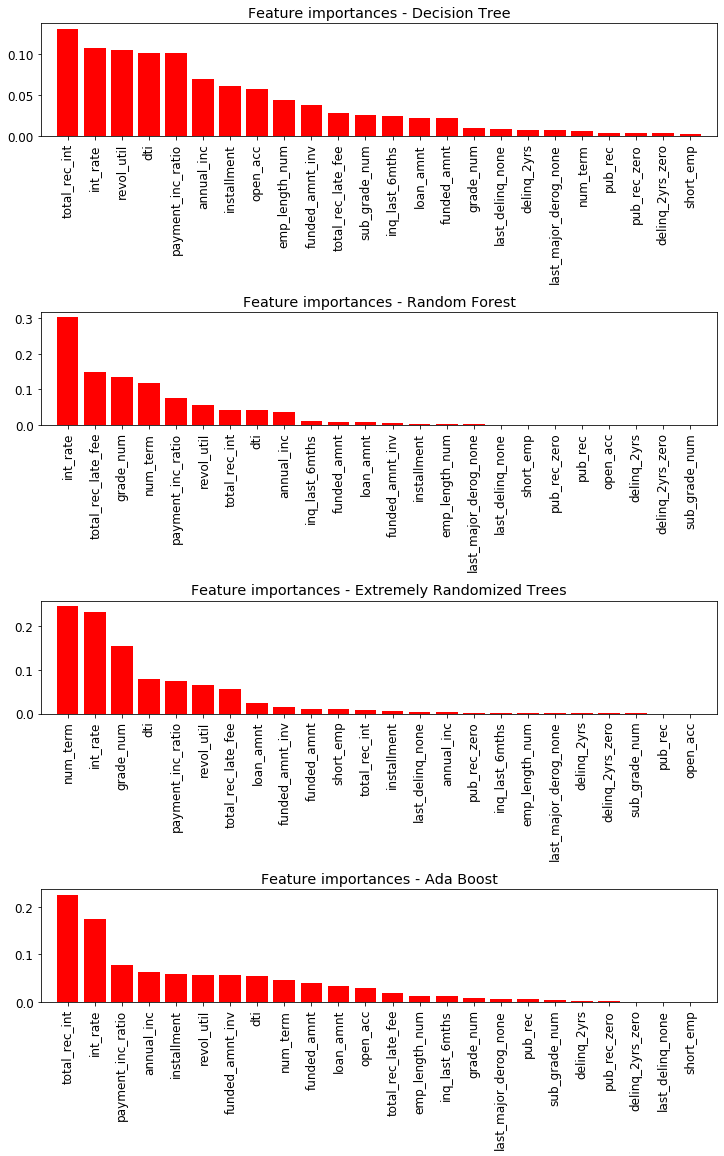

In [14]:
plot_idx = 1

plt.subplots(len(feature_importance_model),1,figsize=(10,4*len(feature_importance_model)))
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)


for model_name in feature_importance_model:
    model = feature_importance_model[model_name][0]
    
    # importance of features
    importances = model.feature_importances_
    
    # indeces of the variables
    indices = np.argsort(importances)[::-1]

    plt.subplot(len(feature_importance_model),1,plot_idx)
    
    # 
    plt.title("Feature importances - "+model_name)
    plt.xticks(range(X.shape[1]),X.columns[indices],rotation='vertical')


    plt.xlim([-1, X.shape[1]])

#     if hasattr(model, 'estimators_'):
#         std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
#         plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")# plt.xticks(range(X.shape[1]), indices)
#     else:
    plt.bar(range(X.shape[1]), importances[indices], color="r")


    plot_idx = plot_idx + 1
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.show()

## Voting Classifier
We can also build an heterogeneous ensemble classifier using a *VotingClassifier* available in [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) that can be built either 
* by specifying a set of methods I selected or
* by using all the methods we tested at once

Let's try to use all the methods we examined so far and let's see how this new ensemble performs. VotingClassifier requires a list of pairs (name,method) so we initially convert the dictionary we used to a list of pairs. Next we apply the same procedure used for the other approaches.

In [15]:
estimators = [x for x in methods.items()]

In [16]:
%%time
clf = VotingClassifier(estimators=estimators, voting='soft')

method_name = 'Voting'

# evaluate the model using crossvalidation
cross_val_score(clf,X,y,cv=crossvalidation)
    
# store the raw results of crossvalidation that we might want to use for t-test/mann-whitney comparison
xval_results['Voting'] = xval_score
    
# compute the basic statistics
accuracy_mean.append(np.average(xval_score))
accuracy_std.append(np.std(xval_score))
    
clf.fit(X_train,y_train)
    
# compute the prediction which, for probabilistic classifiers, is using a threshold of 0.5
yp = clf.predict(X_test)

# ask for the probability values
yprob = clf.predict_proba(X_test)

# computes the data needed to draw the ROC curve
fpr_nb, tpr_nb, thresholds = roc_curve(y_true=y_test, y_score = yprob[:,1], pos_label=1)

# computes the AUC 
roc_auc = roc_auc_score(y_true=y_test, y_score = yprob[:,1])
auc.append(roc_auc)

# store the information to plot the ROC curves afterwards
roc_results[method_name] = (fpr_nb, tpr_nb, thresholds, roc_auc)

precision.append(precision_score(y_test,yp))
recall.append(recall_score(y_test,yp))
f1.append(f1_score(y_test, yp))

print("%10s\tAccuracy  %.3f %.3f"%(method_name,np.average(xval_score),np.std(xval_score)))
print("          \tPrecision %.3f"%precision_score(y_test, yp))
print("          \tRecall    %.3f"%recall_score(y_test, yp))
print("          \tF1        %.3f"%f1_score(y_test, yp))

method.append(method_name)

    Voting	Accuracy  0.820 0.002
          	Precision 0.817
          	Recall    0.993
          	F1        0.897
CPU times: user 12min 14s, sys: 10.4 s, total: 12min 24s
Wall time: 18min 15s


In [17]:
result_summary_extra = pd.DataFrame({'Model':method,'Accuracy (Mean)':accuracy_mean,'Accuracy (Std)':accuracy_std,'Precision':precision,'Recall':recall,'F1':f1,'AUC':auc})
result_summary_extra.to_csv('LoanSafety-Summary-Extra.csv')

In [18]:
result_summary_extra

,Model,Accuracy (Mean),Accuracy (Std),Precision,Recall,F1,AUC
0,Lasso,0.812832,0.001073,0.820863,0.981253,0.893921,0.721683
1,NaiveBayes,0.773056,0.002890,0.840115,0.891479,0.865035,0.682258
2,k-NN(5),0.783908,0.002491,0.816393,0.943547,0.875377,0.557943
3,Decision Tree,0.732733,0.003036,0.841176,0.826984,0.834019,0.580287
4,Bagging(Tree),0.815102,0.000484,0.817868,0.988752,0.895228,0.688886
5,Bagging(kNN),0.803727,0.001406,0.813719,0.979923,0.889121,0.578200
6,Random Forest,0.811264,0.000152,0.810171,1.000000,0.895132,0.707711
7,Extremely Randomized Trees,0.811190,0.000026,0.810171,1.000000,0.895132,0.687081
8,Ada Boost,0.820369,0.001767,0.833372,0.968463,0.895853,0.744297
9,Voting,0.820369,0.001767,0.817144,0.993015,0.896536,0.696573


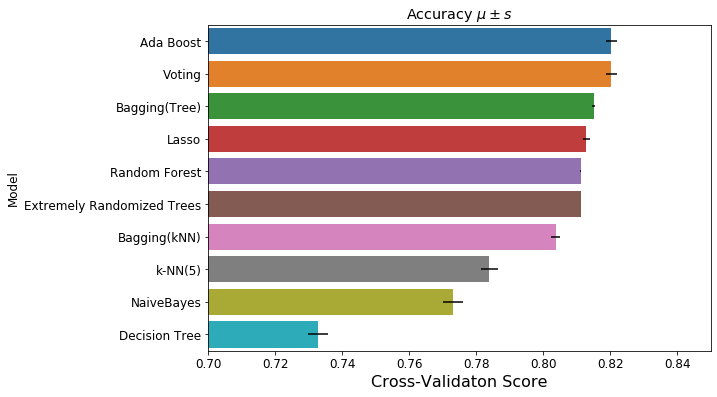

In [19]:
f, axe = plt.subplots(1,1, figsize=(9,6))

result_summary_extra.sort_values(by=['Accuracy (Mean)'], ascending=False, inplace=True)

sns.barplot(x='Accuracy (Mean)', y='Model', data = result_summary_extra, xerr=result_summary_extra['Accuracy (Std)'], ax = axe)
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_title("Accuracy $\mu\pm s$")
axe.set_xlim(0.7,0.85)
plt.show()

## Stacking
Alternatively, we can build a stacking classifier by training a meta classifier to learn how to predict whether a loan is safe based on the prediction of other classifiers. Note that, with respect to the voting classifier, in this case we replace the hard/soft voting with another model. Further examples of stacking can be found at
- http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/
- https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de

We build a dataframe containing the prediction of each model we want to use. Next we train a meta learner on the dataset of predictions we generated. In this case, we use as a meta learner a logistic regression.

### Building the Training Data
The training data are collected by fitting all the models we considered in the stack. 

In [20]:
stack_train = pd.DataFrame()
stack = {}

for method_name in methods:
    clf = methods[method_name]
    clf.fit(X_train,y_train)
    stack[method_name] = clf
    stack_train[method_name] = clf.predict(X_train)


### Training the Meta Learner
Next, the output collected from the stacked models is used to train the meta learner.

In [21]:
meta = LogisticRegression(penalty="l1",C=100, random_state=1234, max_iter=300, solver="liblinear")
meta.fit(stack_train,y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=1234, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
stack_train.head()

,Lasso,NaiveBayes,k-NN(5),Decision Tree,Bagging(Tree),Bagging(kNN),Random Forest,Extremely Randomized Trees,Ada Boost
0,1,1,1,1,1,1,1,1,1
1,1,1,1,-1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1


### Evaluation on the Test Set
To evaluate the performance on the test set we generate a data set containing the output of the fitted models on the test set. The resulting data set (contained in stack_test) is used as the input for the meta model.

In [23]:
stack_test = pd.DataFrame()

for method_name in stack:
    stack_test[method_name] = methods[method_name].predict(X_test)

yp = meta.predict(stack_test)

In [24]:
print("Accuracy %.3f"%(accuracy_score(y_test, yp)))
print("Precision %.3f"%precision_score(y_test, yp))
print("Recall %.3f"%recall_score(y_test, yp))

Accuracy 0.731
Precision 0.841
Recall 0.824


## Final Remarks
We evaluated several classification approaches for predicting the safety of loans. We built a pipeline to evaluate each classifier using cross-validation and holdout. We collected several metrics of performance (accuracy, prediction, recall, f1, AUC). Note that some methods would not have required crossvalidation since they could have been used out-of-bag evaluation, yet we preferred to apply the same evaluation to all the methods to have a uniform comparison. In addition, we applied crossvalidation using accuracy as a metric but accuracy is not the most adequate metric since it does not distinguish between false positive and false negative errors. Depending on the problem we should have used another metric to improve our performance on a specific type of error. There are several other ways to extend the current analysis for example by including other methods or by performing an in-depth exploration analysis which might result in a different data set (e.g., we might apply normalization to the input variables)